# Across-Trials Within Session Testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)
In this tutorial, we are going to look at how to implement the across trials within sessions testing using the [glhmm toolbox](https://github.com/vidaurre/glhmm).
This test  is used to assess effect differences between trials in one or more experimental sessions and is therefore ideal to see trial by trial variability within a session.

In the real world scenarios, one would typically fit a Hidden Markov Model (HMM) to an actual dataset. However, for the sake of showing the concept of statistical testing, we just use synthetic data for both the independent variable  and the dependent variable for the ```across_trials_within_session``` test.

We create synthetic data using the toolbox [Genephys](https://github.com/vidaurre/genephys), developed by Vidaurre in 2023 (accessible at [https://doi.org/10.7554/eLife.87729.2](https://elifesciences.org/reviewed-preprints/87729)). 
[Genephys](https://github.com/vidaurre/genephys) makes it possible to simulate electrophysiological data in the context of a psychometric experiment. Hence, it can create scenarios where, for example, a subject is exposed to one or multiple stimuli while simultaneously recording EEG or MEG data.

While the process of preparing the data requires some explanation, executing the test (```across_trials_within_session```) itself is straightforward —simply input the variables ```D``` and ```R```, and define the specific ```method``` you wish to apply. The methods include permutation using regression or permutation using correlation and is described in the paper [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time).

## Table of Contents
1. [Load and prepare data](#load-data)
    * [Look at data](#look-data)
    * [Prepare data for HMM](#prep_hmm)
2. [Load or initialise and train HMM](#load_hmm)
    * [Data restructuring](#data-recon)
3. [Across-trials within session testing](#across_trials)
    * [Across-trials within sessions testing - Regression](#perm-regression)
    * [Across-trials within sessions testing - Correlation](#perm-correlation)



### Import libraries
Let's start by importing the required libraries and modules.

Furthermore, we will need to import the **GLHMM-package** as ```glhmm```:

If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install --user git+https://github.com/vidaurre/glhmm```

To use the function ```glhmm.statistics.py``` you also need to install the library's:
```
pip install statsmodels
``` 
```
pip install tqdm
``` 


In [1]:
import os
import numpy as np
import pandas as pd
import glhmm.glhmm as glhmm
import glhmm.graphics as graphics
import glhmm.preproc as preproc
import glhmm.statistics as statistics
import glhmm.auxiliary as auxiliary

## 1. Load and prepare data <a id="load-data"></a>
First, we'll load the synthetic data from this [folder](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) and use the [glhmm toolbox](https://github.com/vidaurre/glhmm) to train a classic HMM on the synthetic data that represents EEG or MEG measurements.\
Let's start by loading the essential data for this tutorial:

In [77]:
# Get the current directory
current_directory = os.getcwd()
folder_name = "\\data_statistical_testing" 

# Load D data
file_name = '\\D_trials.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
D_trials = np.load(file_path)

# Load R data
file_name = '\\R_trials.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
R_trials = np.load(file_path).astype(int)


# Load indices
file_name = '\\idx_trials_session.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
idx_trials_session = np.load(file_path)


# Load time indices for every trial
file_name = '\\idx_trials.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
idx_trials = np.load(file_path)


print(f"Data dimension of D-session data: {D_trials.shape}")
print(f"Data dimension of R-session data: {R_trials.shape}")
print(f"Data dimension of indices for each trial: {idx_trials_session.shape}")
print(f"Data dimension of indices: {idx_trials.shape}")

Data dimension of D-session data: (250, 1421, 16)
Data dimension of R-session data: (1421,)
Data dimension of indices for each trial: (10, 2)
Data dimension of indices: (1421, 2)


### Look at data <a id="look-data"></a>
Now we can look at the data structure.
- D_sessions: 3D array of shape (n_timepoints, n_trials, n_features)
- R_sessions: 3D array of shape (n_trials,)
- idx_data: 2D array of shape (n_sessions, 2)

```D_sessions``` represents the data collected from the subject, structured as a list with three elements: ```[250, 1421, 16]```. The first element indicates that the subject underwent measurement across 250 timepoints. The second element, 1421 corresponds to the total number of trials conducted. In this context, 10 distinct sessions were executed, each comprising 150 trials, lead up to a total of 1421 trials (150*10). Each individual trial involved the measurement of 16 channels within the EEG or MEG scanner.

```R_sessions``` categorial values of when a stimulus is prestented. It contain values of 1 and 2. 

```idx_trials_session.shape = [10, 2]``` shows the indices for the number of sessions conducted, which in this case is 10 The values in each row represent the indices for the first and last trial for a given session. As you can see the number of trials are different from each session.
```python
np.diff(idx_trials_session)
array([[129],
       [132],
       [150],
       [150],
       [150],
       [150],
       [150],
       [150],
       [111],
       [149]])
```


Lastly, we have ```idx_trials.shape = [1421, 2]```, which marks the number of trials conducted, which in this case is 1421 The values in each row represent the start and end indices for every trial. Having this index to seperate the time period for each trial is required when training a time-delay embedded HMM (TDE-HMM).

### Prepare data for HMM <a id="prep_hmm"></a>
When you're getting into training a Hidden Markov Model (HMM), the input data needs to follow a certain setup. The data shape should look like ((number of timepoints * number of trials), number of features). This means you've lined up all the trials from different sessions side by side in one long row. The second dimension is the number of features, which could be the number of parcels or channels. 

So, in our scenario, we've got this data matrix, ```D_session```, shaped like ```[250, 1421, 16]``` (timepoints, trials, channels). Now, when we bring all those trials together, it's like stacking them up to create a new design matrix, and it ends up with a shape of ```[355250, 16]``` (timepoints * trials, channels). 
Beside that we also need to update ```R_session``` and ```idx_trials_session``` to sync up  with the newly concatenated data. To make life easier, we've got the function ```get_concatenate_sessions```. It does the heavy lifting for us.

**Note: it is important to use ```idx_trials_session``` for this function as the concatenation is done trial-by-trial basis for every defined session.**

In [6]:
D_con,R_con,idx_con=statistics.get_concatenate_sessions(D_trials, R_trials, idx_trials_session)
print(f"Data dimension of the concatenated D-data: {D_con.shape}")
print(f"Data dimension of the concatenated R-data: {R_con.shape}")
print(f"Data dimension of the updated time stamp indices: {idx_con.shape}")

Data dimension of the concatenated D-data: (355250, 16)
Data dimension of the concatenated R-data: (355250,)
Data dimension of the updated time stamp indices: (10, 2)


For a quick sanity check, let's verify whether the concatenation was performed correctly on ```D_trials```. We've essentially stacked up every timepoint from each trial sequentially.

To do this, we can compare a slice of our original design matrix, say ```D_trials[:, 0, :]```, with the corresponding slice in the concatenated data, ```D_con[0:250, :]```.\
If the comparison ```D_trials[:, 0, :] == D_con[0:250, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 250 values in our concatenated data. It's like double-checking to make sure everything lined up as expected.

In [7]:
D_trials[:,0,:]==D_con[0:250,:]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

Here, it's evident that the concatenation process has been executed accurately.

Next up, let's confirm if the values in ```idx_con``` have been appropriately updated. Each row in this matrix should represent the total count of timepoints and trials for each of the 10 sessions. 

In [8]:
idx_con

array([[     0,  32250],
       [ 32250,  65250],
       [ 65250, 102750],
       [102750, 140250],
       [140250, 177750],
       [177750, 215250],
       [215250, 252750],
       [252750, 290250],
       [290250, 318000],
       [318000, 355250]])

Indeed, each session now aligns with the number of datapoints. This means that when we pooled together the timepoints and trials, the count for each session ended up exactly as expected. It's a reassuring confirmation that our concatenation didn't miss a beat.

## 2. Load data or initialise and train HMM <a id="load_hmm"></a>
You can either load the ```Gamma``` values from a pretrained model or train your own model. If you prefer the former option, load up the data from the [data_statistical_testing](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) folder. In this example we have trained a TDE-HMM, incorporating mean and covariance parameters for 6 distinct states.
TDE-HMM calculates the covariance and then compares the covariance at different time points. If the covariances are similar, the time points are assigned to the same state; otherwise, they are assigned to different states.

```python
current_directory = os.getcwd()
folder_name = "\\data_statistical_testing" 

# Load Gamma data
file_name = '\\Gamma_trials.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
Gamma_tde = np.load(file_path)
print(f"Data dimension of Gamma: {Gamma.shape}")
```
If you decide to train your own TDE-HMM model, you need to prepare the dataset by adding lags that act like a sliding window. These lags capture temporal dependencies in the data and span from -n to n, passing through zero. The code below shows how to define such lags:

```python
# Create lag array
lag_val =list(range(-7, 8, 1))
print(lag_val)
[-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7]
```
Once the dataset is appropriately prepared, you can proceed with training the TDE-HMM.

In [10]:
# Define the number of lags (Window size)
lag_val =list(range(-7, 8, 1))

We can now prepare the dataset by using the following function ```preproc.build_data_tde```, so it is ready for the TDE-HMM.\
The inputs will be the concatenated data (```D_con```), the indices that defines the running period for each trial (```idx_trials```) of the concatenated data, and the lag kernel (```lag_val```) that will run over each trial.

In [13]:
idx_trials

array([[     0,    250],
       [   250,    500],
       [   500,    750],
       ...,
       [354500, 354750],
       [354750, 355000],
       [355000, 355250]])

In [12]:
# Prepare the dataset for TDE-HMM
D_con_tde,idx_tde = preproc.build_data_tde(D_con, idx_trials,lag_val)

In [56]:
print(f"Data dimension of the concatenated TDE D-data: {D_con_tde.shape}")
print(f"Data dimension of the updated TDE time stamp indices: {idx_tde.shape}")

Data dimension of the concatenated TDE D-data: (335356, 240)
Data dimension of the updated TDE time stamp indices: (1421, 2)


Upon examination, you'll notice that the dimension of the concatenated TDE D-data has undergone a transformation from (355250, 16) to (335356, 240).

This transformation is a result of the specified kernel size for the lag, applied individually to each trial. The defined lag kernel ranges from -7 to 7, indicating that we have pooled/excluded 7 data points from both the beginning and end of each trial. In essence, the original trial length of 250 time points has been reduced to 236 (250 - 14).

This adjustment applies for all 1421 trials in our dataset. Initially, the total number of data points in the concatenated data was 355250 (1421 * 250), as indicated at the beginning of this notebook when we loaded the data. However, after processing, ```D_con_tde``` now contains 335356 data points, equivalent to 1421 * 236.

If look into ```idx_tde```, we can see that the number period for each trial are 236 points, which match with the pooled 7 data points from both the beginning and end of each trial based on the defined ```lag_val```

Checking out idx_tde, you'll notice that each trial now spans 236 points, matching the 7 pooled data points from both ends based on the specified kernel size of ```lag_val```.


In [14]:
idx_tde

array([[     0,    236],
       [   236,    472],
       [   472,    708],
       ...,
       [334648, 334884],
       [334884, 335120],
       [335120, 335356]])

### Initialize-HMM <a id="HMM-initialize"></a>
If you want to train your own HMM you need to do the following steps. First, we need to initialize the ```hmm``` object and set the hyperparameters according to our modeling preferences.

In this case, we choose not to model an interaction between two sets of variables in the HMM states, so we set ```model_beta='no'```. For our estimation, we choose ```K=6``` states. If you wish to model a different number of states, simply adjust the value of ```K```.

Our modeling approach involves representing states as Gaussian distributions with mean and a full covariance matrix. This means that each state is characterized by a mean amplitude and a functional connectivity pattern. To specify this configuration, set ```covtype='full'```. If you prefer not to model the mean, you can include ```model_mean='no'```. Optionally, you can check the hyperparameters to make sure that they correspond to how you want the model to be set up.

In [60]:
# Create an instance of the glhmm class
K = 6 # number of states
hmm = glhmm.glhmm(model_beta='no', K=K, covtype='full')
print(hmm.hyperparameters)

{'K': 6, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True,  True,  True])}


### Train an HMM <a id="HMM-train"></a>
Now, let's proceed to train the TDE-HMM using the data (```D_con_tde```) and time indices (```idx_tde```).

Since in this case, we are not modeling an interaction between two sets of timeseries but opting for a "classic" HMM, we set ```X=None```. For training, ```Y``` should represent the timeseries from which we aim to estimate states (```D_con_tde```), and indices should encompass the beginning and end indices of each subject (```idx_tde```).



In [45]:
Gamma_tde,Xi,FE = hmm.train(X=None, Y=D_con_tde, indices=idx_tde)

Init repetition 1 free energy = 10100560.389714964
Init repetition 2 free energy = 10093956.407964487
Init repetition 3 free energy = 10090550.266245814
Init repetition 4 free energy = 10113470.278333537
Init repetition 5 free energy = 10099919.246710643
Best repetition: 3
Cycle 1 free energy = 10096422.69177867
Cycle 2 free energy = 10087737.890692819
Cycle 3, free energy = 10085966.155647676, relative change = 0.16943804553891703
Cycle 4, free energy = 10085213.086363163, relative change = 0.06718071302241105
Cycle 5, free energy = 10084614.99427202, relative change = 0.05065272808744635
Cycle 6, free energy = 10084041.424123276, relative change = 0.046325640048161774
Cycle 7, free energy = 10083419.680980332, relative change = 0.04781532158870076
Cycle 8, free energy = 10082703.030555211, relative change = 0.05223528580252741
Cycle 9, free energy = 10081848.503019355, relative change = 0.05863294005367324
Cycle 10, free energy = 10080815.242994325, relative change = 0.06620300596895

Now, checking out ```Gamma```, you'll see it's got the same number of points as the concatenated dataset (335356 ). Each column in Gamma stands for one of the six different states.

In [24]:
Gamma_tde.shape

(335356, 6)

**Reconstruct the shape of Gamma**\
Now, let's reshape Gamma to match the original dataset by padding the data. We'll use the ```auxiliary.padGamma``` function, which takes ```Gamma```, ```T```, and ```option``` as inputs.
* ```Gamma```: This is the Gamma we obtained from the TDE-HMM.
* ```T```: Represents the desired number of data points for each trial, which needs to go back from 236 to 250. We can obtain ```T``` using the ```auxiliary.get_T``` function, which requires the original indices ```idx_trials``` as input.
* ```option```: A dictionary where the key can be either "embeddedlags" or "order". Since we're using lags in this case, we set the key to "embeddedlags," and the value is the variable ```lag_val```.


In [25]:
# Get T
T = auxiliary.get_T(idx_trials)
# Define options
options ={'embeddedlags':lag_val}
Gamma =auxiliary.padGamma(Gamma_tde,T,options=options)

Examine Gamma

In [33]:
#Look at shape for Gamma and D_con
Gamma.shape, D_con.shape

((355250, 6), (355250, 16))

Now, you'll notice that the number of data points in both ```Gamma``` and ```D_con``` are back in sync.

Taking a closer look at the padding for the initial trial in state 1, you can observe that padding has been applied to the first 7 data points and the last 7 data points.



In [29]:
# As we can see the padding works, since the first and last 7 numbers
# has been added to the timepoints for every trial
Gamma[:10,0].round(3),Gamma[240:250,0].round(3)

(array([0.358, 0.358, 0.358, 0.358, 0.358, 0.358, 0.358, 0.   , 0.   ,
        0.   ]),
 array([0.968, 0.998, 0.999, 0.358, 0.358, 0.358, 0.358, 0.358, 0.358,
        0.358]))

## Data restructuring <a id="data-recon"></a>
Now we have trained our HMM and got our ```Gamma```  values we need to restructure the data back to the original data structure. In this case we are not doing HMM-aggregated statistics, but we will instead perform the statistical testing per time point. 
We will acheive this by applying the function ```reconstruct_concatenated_design```. It takes a concatenated 2D matrix and converts it into a 3D matrix. 
So, it will convert  ```Gamma```, shaped like ```[355250, 6]``` back to the original format for number of time points and trials shaped like ```[250, 1421, 6]``` (timepoints, trials, states).

In [72]:
# Reconstruct the Gamma matrix
n_timepoints, n_trials, n_channels = D_trials.shape[0],D_trials.shape[1],Gamma.shape[1]
Gamma_reconstruct =statistics.reconstruct_concatenated_design(Gamma,n_timepoints=n_timepoints, n_trials=n_trials, n_channels=n_channels)
Gamma_reconstruct.shape

(250, 1421, 6)

As a sanity check we will see if ```Gamma_reconstruct``` is actually structured correctly by comparing it with ```Gamma```.

To do this, we can compare a slice of our 3D-matrix, like ```Gamma_reconstruct[:, 0, :]```, with the corresponding slice in the concatenated 2D-data, ```Gamma[0:250, :]```.\
If the comparison ```Gamma_reconstruct[:, 0, :] == Gamma[0:250, :]``` holds true, we're essentially confirming that all timepoints in the first trial align perfectly with the first 250 values in our concatenated data. 



In [73]:
Gamma_reconstruct[:, 0, :] == Gamma[0:250, :]

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       ...,
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

What we can see here is that all the values are **True** and we therefore know that the restructuring is performed correctly. 

## 3. Across-trials within session testing <a id="across_trials"></a>
As we move on to the next part of this tutorial, let's dive into how we can use the ```across_trials_within_subject``` function.
This function helps us to find connections between HMM state occurrences (D) and behavioral variables or individual traits (R) using permutation testing.


**Permutation testing**\
Permutation testing does not assume any particular data distribution and the procedure shuffles the data around to create a null distribution. This null distribution comes in handy for testing our hypotheses without making any bold assumptions about the data.
This null distribution becomes our benchmark to test the big question: is there any real difference or relationship between the variables we're interested in?

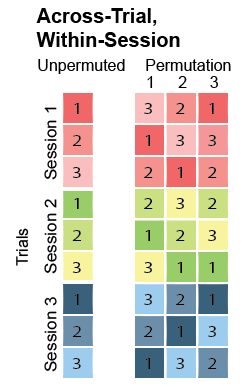

**Figure 5C** in [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time): A 9 x 4 matrix representing permutation testing across trials. Each number corresponds to a trial within a session, and permutations are performed within sessions.


**Hypothesis**
* Null Hypothesis (H0): No significant relationship exists between the independent variables and the dependent variable.
* Alternative Hypothesis (H1): There is a significant relationship between the independent variables and the dependent variable. 



### Across-trials within sessions testing - Regression<a id="perm-regression"></a>
In regression analysis, we are trying to explain the relationships between predictor variables (D) the response variable (R). Our goal is to identify the factors that contribute to changes in our signal over time. The permutation test for explained variance assess the statistical significance of relationships between state time courses (D) and behavioral measurements (R). A significant result indicates that certain patterns within the state time courses (```Gamma_reconstruct```) significantly contribute in explaining why the behavioral measurements varies across trials. A non-significant result suggests that he state time courses may not play a role in accounting for the variability of the behavioral measurements.


**Run the across_trials_within_session function:**\
To set the wheels in motion for the ```across_trials_within_session``` function, input the variables ```Gamma_reconstruct``` (D) and ```R_trials``` (R). Additionally, you can account for potential confounding variables by regressing them out through permutation testing. Initiating regression-based permutation testing involves setting ```method="regression"```. For an in-depth comprehension of the function look at the documentation.

In [94]:
# Set the parameters for across sessions within subject testing
method = "regression"
Nperm = 1000 # Number of permutations (default = 1000)
# Perform across-trial testing
result_regression  =statistics.across_trials_within_session(Gamma_reconstruct, R_trials, idx_trials_session,method=method,Nperm=Nperm)

performing permutation testing per timepoint


100%|██████████| 250/250 [01:03<00:00,  3.91it/s]


We can now examine the local ```result_regression``` variable.

In [20]:
result_regression

{'pval': array([0.18981019, 0.19280719, 0.2037962 , 0.20679321, 0.22477522,
        0.22377622, 0.21678322, 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999  , 0.002997  , 0.01198801,
        0.01698302, 0.02097902, 0.003996  , 0.000999  , 0.000999  ,
        0.000999  , 0.000999  , 0.000999

What we can see here is that ```result_regression``` is a dictionary containing the outcomes of a statistical analysis conducted using the specified ```method``` and ```test_type```. 

Let us break it down:
* ```pval```: This array houses the p-values generated from the permutation test.

* ```corr_coef```: Currently an empty list, it is designated to store correlation coefficients if the analysis involves correlation. In this instance, correlation coefficients are not calculated when we set ```method="regression"```.


* ```test_statistic```: Currently an empty list, this list can store the test statistics associated with the permutation test. It offers additional insights into the permutation distribution used for p-value calculations. The output is exported if ```test_statistic_option=True```.

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_visits```.

* ```method```: method: Specifies the analytical method employed, which is ```'regression'```, which means that the analysis is carried out using regression-based permutation testing.


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

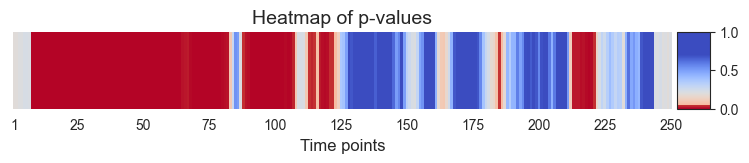

In [33]:
# Plot p-values
graphics.plot_heatmap(result_regression["pval"], title_text ="Heatmap of p-values",figsize=(9, 1), xlabel="Time points", annot=False)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

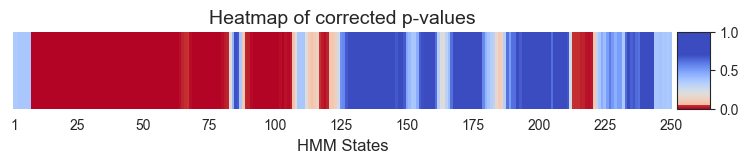

In [34]:
pval_corrected, rejected_corrected =statistics.pval_test(result_regression["pval"], method='fdr_bh')
# Plot p-values
graphics.plot_heatmap(pval_corrected, title_text ="Heatmap of corrected p-values",figsize=(9, 1), xlabel="HMM States", ylabel="", annot=False)

Instead of using a heatmap, we can also visualize the results with a scatter plot.\
We will use the function ```plot_scatter_with_labels``` from the ```graphics``` module.

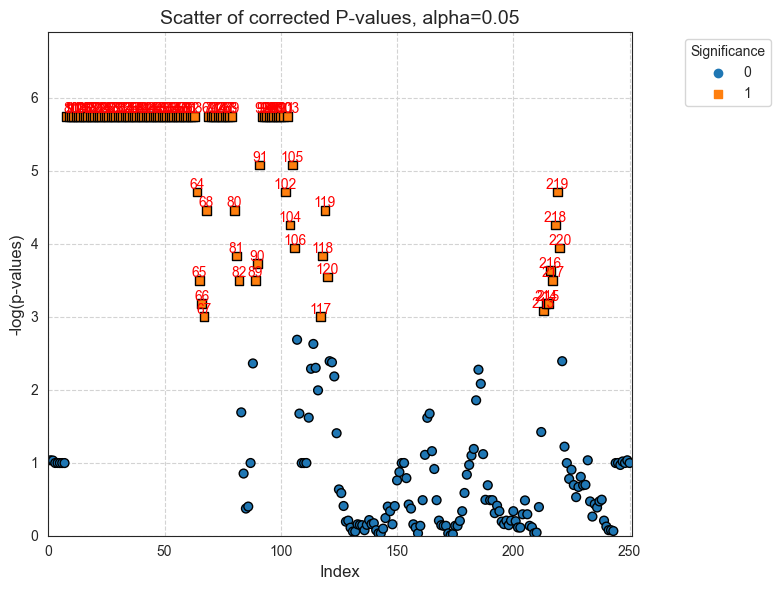

In [32]:
# Set the threshold of alpha to be 0.05
alpha=0.05
title_text = f"Scatter of corrected P-values, alpha={alpha}"
graphics.plot_scatter_with_labels(pval_corrected,alpha=alpha ,xlim_start=-0.1,ylim_start=0, title_text=title_text,)

**Visualize average probabilities and differences**\
We can now compare if the results from ```result_regression["pval"]``` correspond to the difference for each state over time for the two conditions. This will be done using the function ```plot_condition_difference```.



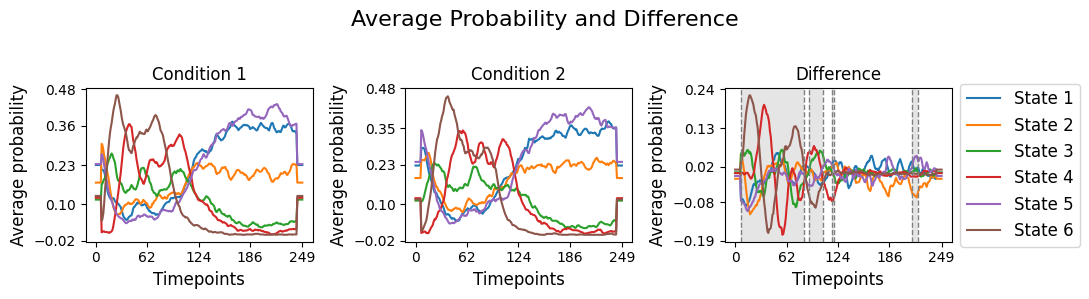

In [103]:
# Plot the average probability for each state over time for two conditions and their difference.
# Defining the areas that shows a significant difference
vertical_lines=[(7, 83),(89, 106),(117,119),(213,220)]
graphics.plot_condition_difference(Gamma_reconstruct, R_trials, figsize=(11,3),vertical_lines=vertical_lines , highlight_boxes=True)


#### Conclusion - Regression
Our exampled involved presenting participants with two distinct stimuli across multiple trials spanning 10 different sessions. Permutation testing was performed across all trials within each session while while keeping the session order the same. The analysis generated the variable result_regression["pval"], containing 250 p-values for each time point.

After correcting for multiple comparisons using Benjamini/Hochberg, significant differences were mainly in the early and mid segments of the signal (specifically, timepoints 7 to 83, 89 to 106 and 117 to 119) between state time courses (D) and stimuli (R).

The consistent occurrence of significant effects in the early segments of the recordings for every trial suggests a robust and reliable neural reaction at the onset of the stimuli. On the other hand, the decreasing significance towards the end of the signal may indicate a diminishing neural response to the presented stimuli over time. This temporal pattern in the results implies an initial heightened attention or processing of the stimuli, followed by a reduction in neural responsiveness as the trial progresses. The findings thus provide insights into the temporal dynamics of neural responses, indicating specific time windows of heightened sensitivity. 

### Across-trials within sessions testing - Correlation<a id="perm-correlation"></a>
In correlation analysis, our goal is to find connections between predictor variables (D) and the response variable (R). Instead of explaining the variations in signal values over time, as in regression, our interest lies in figuring out the strength of the linear relationship between the state time courses (```Gamma_reconstruct```) and behavioral measurements, such as our stimuli. If the result is significant, it means that certain patterns in the state time courses (```Gamma_reconstruct```) contribute to explaining the variability in behavioral measurements across trials. Now if the results is non-significant, it indicates that the observed relationship might just be a random chance. It means that our state time courses might not explain the variability in behavioral measurements.

**Executing the across_trials_within_session function**:\
To initiate the ```across_trials_within_session``` function using correlation, input the variables ```Gamma_reconstruct``` (D) and ```R_session``` (R). Additionally, you can address potential confounding variables by incorporating permutation testing.\
Quick reminder: for correlation-based permutation testing, go with ```method="correlation"``` to get the correlation coefficients, and if you want both correlation coefficients and p-values, try ```method="correlation_com"```.


In [44]:
# Set the parameters for between-subject testing
method = "correlation_com"
Nperm = 1000 # Number of permutations (default = 1000)
# Perform across-subject testing
result_correlation  =statistics.across_trials_within_session(Gamma_reconstruct, R_trials, idx_trials_session,method=method,Nperm=Nperm)

performing permutation testing per timepoint


100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value matrix.\
We will use the function ```plot_heatmap``` from the ```graphics``` module.

Note: Elements marked in red indicate a p-value below 0.05, signifying statistical significance.

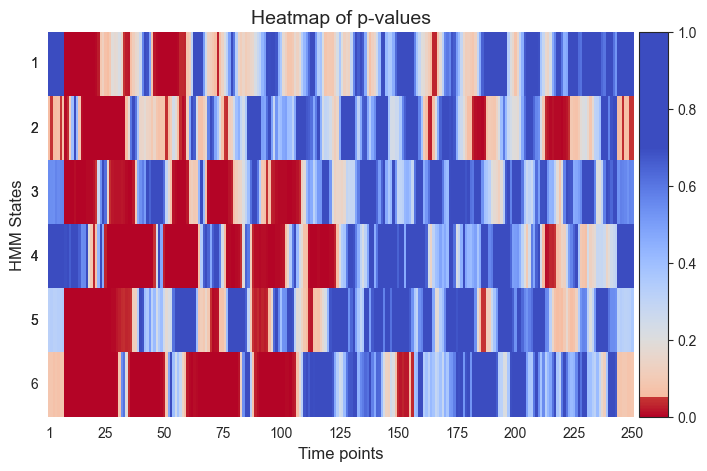

In [48]:
# Plot p-values
graphics.plot_heatmap(result_correlation["pval"].T, title_text ="Heatmap of p-values",figsize=(8, 5), xlabel="Time points", ylabel="HMM States", annot=False)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

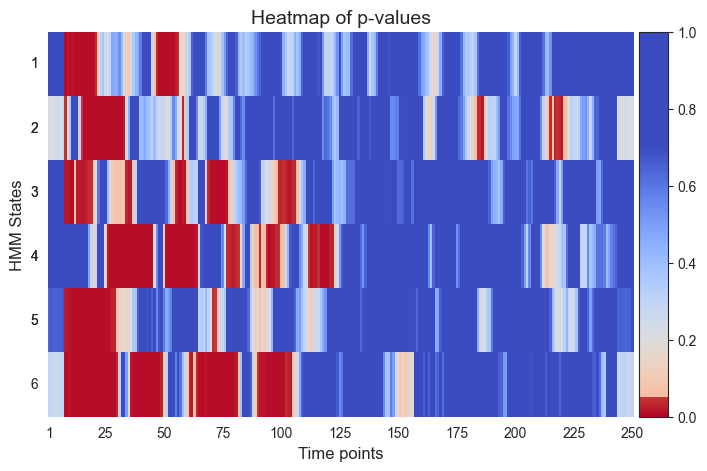

In [50]:
pval_corrected, rejected_corrected =statistics.pval_test(result_correlation["pval"], method='fdr_bh', alpha=0.5)
# Plot p-values
graphics.plot_heatmap(pval_corrected.T, title_text ="Heatmap of p-values",figsize=(8, 5), xlabel="Time points", ylabel="HMM States", annot=False)

Plot Correlation Coefficients

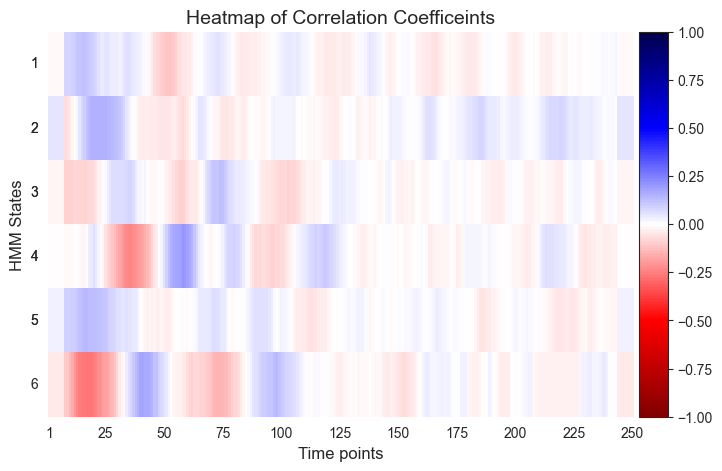

In [51]:
# Plot correlation coefficients
# Correlations between reation time and each state as function of time
graphics.plot_heatmap(result_correlation["corr_coef"].T, plot_method="corr_coef", title_text ="Heatmap of Correlation Coefficeints",figsize=(8, 5), xlabel="Time points", ylabel="HMM States", annot=False)

#### Conclusion - Correlation
In this example, the permutation testing analysis using correlation aims to study the relationship between state time courses and two different stimuli across multiple experimental trials.  The resulting matrix, ```result_correlation["pval"]```, is structured as (time points x states), and it shows the trial-specific variations in the correlation between state time courses at every timepoint and the stimuli. Essentially, this matrix offers information about time-dependent and state-specific correlation patterns.

Upon correcting the p-values using Benjamini/Hochberg, significant p-value for a specific HMM state and timepoint means that the correlation between state time courses at that timepoint and the stimuli significantly varies across experimental trials. This suggest that it is possible to pinpoint instances when changes in stimuli impact the state time courses, and thus highlight moments when stimuli induce observable effects on the state dynamics.

When looking at ```result_correlation["pval"]```, we observe time windows that shows a significant difference in the correlation between different HMM states and the stimuli. This can be interpreted as distinctive periods when specific neural states exhibit heightened responsiveness or susceptibility to the presented stimuli.
